In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os, sys, time, random

from ROOT import TTree, TFile

# from root_numpy import root2array, rec2array, array2root

import pandas as pd
import numpy as np
import scipy 
import root_pandas as rp
import root_numpy as ry 

import pandas.core.common as com
from pandas.core.index import Index
from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix

from tqdm import tqdm_notebook

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.externals import joblib
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score

sys.path.append('/home/chasenberg/repos/')
sys.path.append('/home/chasenberg/repos/dopy')
from dopy import * 
from dopy.dolearn.sklearn_utils import plot_roc_curve, plot_classifier_output, plot_correlations
from dopy.dolearn.sklearn_utils import plot_feature_importances, plot_classifier_output, classify_unseen_data
#from dopy.sklearn_utils import plot_bdt_vars
from dopy.doplot.plotting import Plotter, Plot
from dopy.doanalysis.df_utils import add_min_max, add_eta 

/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
variables = [
'B0_M',
'B0_FitDaughtersConst_M',
'B0_FitDaughtersConst_chi2',
'B0_FitDaughtersConst_IPCHI2',
'B0_FitDaughtersConst_J_psi_1S_IP',   
'B0_FitDaughtersConst_KS0_P1_PT',
'B0_FitDaughtersConst_KS0_P0_PT',  
'B0_FitDaughtersConst_KS0_decayLength',
'B0_FitDaughtersConst_KS0_IP',
'B0_FitDaughtersConst_KS0_P0_IPCHI2', 
'B0_FitDaughtersConst_J_psi_1S_IPCHI2',
'B0_L0MuonDecision_TOS',
'B0_Hlt1TrackMuonDecision_TOS',
'B0_Hlt2DiMuonJPsiDecision_TOS',
'B0_M',
'idxPV',
'piminus_TRACK_Type',
'B0_FitPVConst_status',
'B0_FitDaughtersConst_KS0_P1_PT', 
'B0_FitDaughtersConst_KS0_P0_PT',
'B0_FitDaughtersConst_KS0_P0_IPCHI2', 
'B0_FitDaughtersConst_KS0_P1_IPCHI2',
'B0_FitDaughtersConst_J_psi_1S_P0_PT', 
'B0_FitDaughtersConst_J_psi_1S_P1_PT',
'B0_FitPVConst_KS0_tau',
'B0_FitPVConst_KS0_tauErr',
'SigYield_sw'
]
variables_mc = [
'B0_M',
'B0_FitDaughtersConst_M',
'B0_FitDaughtersConst_chi2',
'B0_FitDaughtersConst_IPCHI2',
'B0_FitDaughtersConst_J_psi_1S_IP',   
'B0_FitDaughtersConst_KS0_P1_PT',
'B0_FitDaughtersConst_KS0_P0_PT',  
'B0_FitDaughtersConst_KS0_decayLength',
'B0_FitDaughtersConst_KS0_IP',
'B0_FitDaughtersConst_KS0_P0_IPCHI2', 
'B0_FitDaughtersConst_J_psi_1S_IPCHI2',
'B0_L0MuonDecision_TOS',
'B0_Hlt1TrackMuonDecision_TOS',
'B0_Hlt2DiMuonJPsiDecision_TOS',
'B0_M',
'idxPV',
'piminus_TRACK_Type',
'B0_FitPVConst_status',
'B0_FitDaughtersConst_KS0_P1_PT', 
'B0_FitDaughtersConst_KS0_P0_PT',
'B0_FitDaughtersConst_KS0_P0_IPCHI2', 
'B0_FitDaughtersConst_KS0_P1_IPCHI2',
'B0_FitDaughtersConst_J_psi_1S_P0_PT', 
'B0_FitDaughtersConst_J_psi_1S_P1_PT',
'B0_FitPVConst_KS0_tau',
'B0_FitPVConst_KS0_tauErr',
'B0_BKGCAT'
]

In [3]:
#directories and files 
data_dir_2015 = '/fhgfs/users/chasenberg/data/2015/jpsiks/sweights/'
data_file_2015 ='Bd2JpsiKS_data_2015_flattened_sw.root'
data_dir_2016 = '/fhgfs/users/chasenberg/data/2016/jpsiks/sweights/'
data_file_2016 ='Bd2JpsiKS_data_2016_flattened_sw.root'

mc_dir = '/fhgfs/users/chasenberg/mc/2015/jpsiks/dimuon_stripping/flattened/'
mc_file = 'Bd2JpsiKS_dimuon_mc_2015_flattened.root'

data_dir_2015 = os.path.join(data_dir_2015, data_file_2015)
data_dir_2016 = os.path.join(data_dir_2016, data_file_2016)
mc_dir = os.path.join(mc_dir, mc_file)

In [4]:
#criteria and information for read in mc
cut_string_mc = 'B0_FitDaughtersConst_status==0&B0_FitPVConst_status==0&idxPV==0&B0_FitDaughtersConst_M<5350&B0_FitDaughtersConst_M>5220&((B0_BKGCAT==10)|(B0_BKGCAT==50))&((B0_L0Global_TOS==1)|(B0_Hlt1DiMuonHighMassDecision_TOS==1)|(B0_Hlt2DiMuonDetachedJPsiDecision_TOS==1))'
tree_mc = 'Bd2JpsiK'

In [5]:
#Treename for data
tree_data = 'Bd2JpsiKs'

In [6]:
#read root files
#2015 data
real_dataframe_2015 = rp.read_root(data_dir_2015,key=tree_data,columns=variables)
real_dataframe_2015 = real_dataframe_2015.replace([np.inf, -np.inf], np.nan)
real_dataframe_2015 = real_dataframe_2015.dropna()
#2016 data
real_dataframe_2016 = rp.read_root(data_dir_2016,key=tree_data,columns=variables)
real_dataframe_2016 = real_dataframe_2016.replace([np.inf, -np.inf], np.nan)
real_dataframe_2016 = real_dataframe_2016.dropna()

signal_df = rp.read_root(mc_dir,key=tree_mc,columns=variables_mc,where=cut_string_mc, flatten=True)
signal_df = signal_df.replace([np.inf, -np.inf], np.nan)
signal_df = signal_df.dropna()

In [7]:
print("In 2015 there are",real_dataframe_2015.shape[0],"events in Bd2JpsiKS.")
print("In 2016 there are",real_dataframe_2016.shape[0],"events in Bd2JpsiKS.")
print("In 2015 there are",signal_df.shape[0],"events in Bd2JpsiKS Monte-Carlo.")

In 2015 there are 347071 events in Bd2JpsiKS.
In 2016 there are 1516473 events in Bd2JpsiKS.
In 2015 there are 17924 events in Bd2JpsiKS Monte-Carlo.


In [8]:
#Merge 2015 and 2016 data
real_df = pd.concat([real_dataframe_2015,real_dataframe_2016])

Add variables to dataframe
--------------------------


In [9]:
#add symmetrical variables to dataframe
from dopy.doplot.selection import add_log_to_dataframe, add_max_to_dataframe, add_min_to_dataframe
#choose minimal value of both myon transversal momentums
add_min_to_dataframe(real_df, 'B0_FitDaughtersConst_KS0_min_PT', ['B0_FitDaughtersConst_KS0_P1_PT', 'B0_FitDaughtersConst_KS0_P0_PT'])
add_min_to_dataframe(signal_df, 'B0_FitDaughtersConst_KS0_min_PT', ['B0_FitDaughtersConst_KS0_P1_PT', 'B0_FitDaughtersConst_KS0_P0_PT'])

#choose minimal value of both pions ipchi2
add_min_to_dataframe(real_df, 'test_IP', ['B0_FitDaughtersConst_KS0_P0_IPCHI2', 'B0_FitDaughtersConst_KS0_P1_IPCHI2'])
add_min_to_dataframe(signal_df, 'test_IP', ['B0_FitDaughtersConst_KS0_P0_IPCHI2', 'B0_FitDaughtersConst_KS0_P1_IPCHI2'])

#choose minimal value of both myons transversal momentum
add_min_to_dataframe(real_df, 'B0_FitDaughtersConst_J_psi_1S_min_PT', ['B0_FitDaughtersConst_J_psi_1S_P0_PT', 'B0_FitDaughtersConst_J_psi_1S_P1_PT'])
add_min_to_dataframe(signal_df, 'B0_FitDaughtersConst_J_psi_1S_min_PT', ['B0_FitDaughtersConst_J_psi_1S_P0_PT', 'B0_FitDaughtersConst_J_psi_1S_P1_PT'])

#Generate dimensionless decay-time distribution
real_df['B0_FitPVConst_KS0_tau_dimless'] = real_df['B0_FitPVConst_KS0_tau']/real_df['B0_FitPVConst_KS0_tauErr']
signal_df['B0_FitPVConst_KS0_tau_dimless'] = signal_df['B0_FitPVConst_KS0_tau']/signal_df['B0_FitPVConst_KS0_tauErr']

#Add pseudo weights on MC dataframe
mc_weight = np.ones(signal_df['B0_FitDaughtersConst_M'].count())
signal_df['mc_weight'] = mc_weight

In [10]:
#Produce track-type dataframes
#dd events
dd_frame = real_df.query('piminus_TRACK_Type==5')
dd_mc = signal_df.query('piminus_TRACK_Type==5')
#ll events
ll_frame = real_df.query('piminus_TRACK_Type==3')
ll_mc = signal_df.query('piminus_TRACK_Type==3')

In [11]:
bdt_features = [
'B0_FitDaughtersConst_chi2',
'B0_FitDaughtersConst_IPCHI2',
'B0_FitDaughtersConst_J_psi_1S_IP',   
'B0_FitDaughtersConst_KS0_P1_PT',
'B0_FitDaughtersConst_KS0_P0_PT',  
'B0_FitDaughtersConst_KS0_min_PT',
'B0_FitDaughtersConst_KS0_decayLength',
'B0_FitPVConst_KS0_tau_dimless',
#'test_IP',
'B0_FitDaughtersConst_KS0_IP',
'B0_FitDaughtersConst_KS0_P0_IPCHI2', 
#'B0_FitDaughtersConst_J_psi_1S_IPCHI2',
'B0_FitDaughtersConst_J_psi_1S_min_PT',
'B0_FitDaughtersConst_J_psi_1S_P0_PT'
]

Simple check of sWeighted data against monte-carlo
----------------------------------------------------------------------

In [12]:
#del signal_df['B0_BKGCAT']
#del signal_df['__array_index']
#Just a check
#signal_df.shape, real_df.shape 

In [13]:
test = real_df['B0_FitDaughtersConst_chi2'].quantile(1)
real_df.shape, test

((1863544, 27), 10805.07421875)

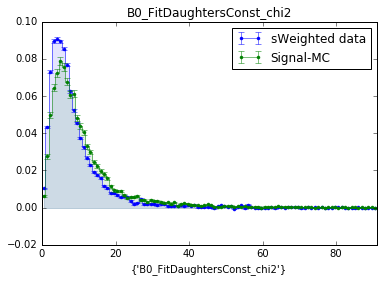

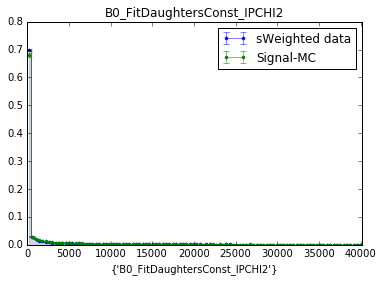

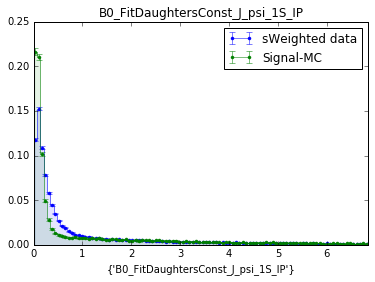

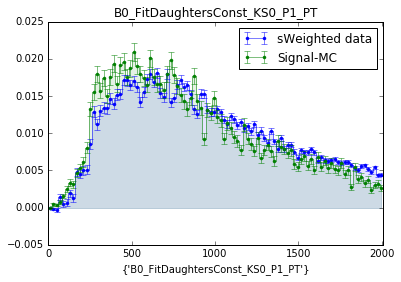

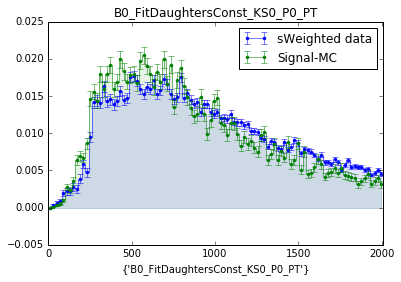

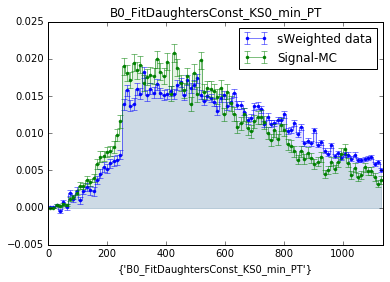

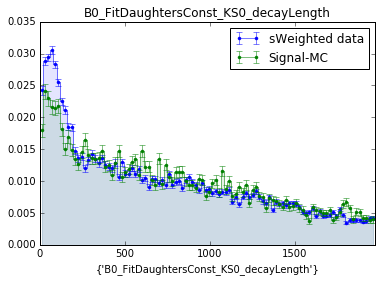

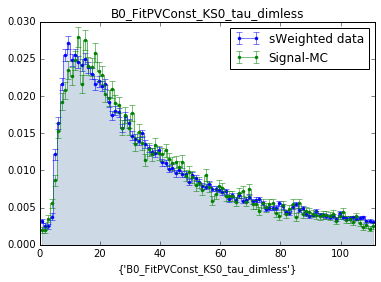

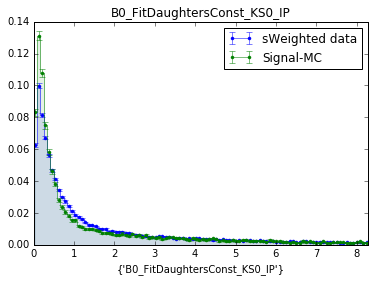

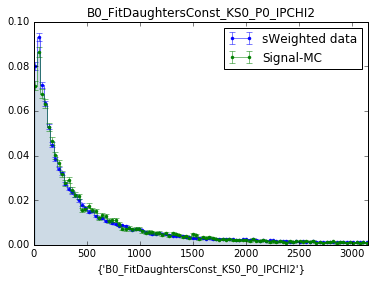

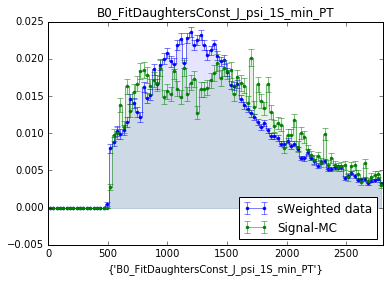

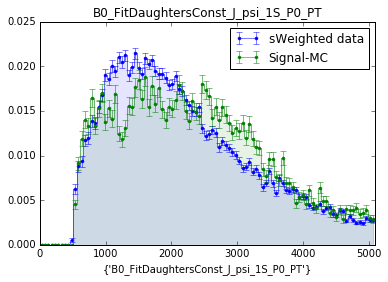

In [14]:
#Check bdt-variables 
for feature in bdt_features:
    plotter = Plotter('/home/chasenberg/repos/b2cc_sin2beta/notebooks/selection/plots/bdt_check/')
    plotter.create_plots([real_df,signal_df], feature, weightvars=['SigYield_sw','mc_weight'],component_labels=['sWeighted data','Signal-MC'])
    plotter[feature].set_range(0,real_df[feature].quantile(0.95))
    plotter.plot()

Check fractions of the DD/LL type events
-----------------------------------------------------------

In [15]:
#add symmetrical variables to dataframe
from dopy.doplot.selection import add_log_to_dataframe, add_max_to_dataframe, add_min_to_dataframe
#choose minimal value of both myon transversal momentums
add_min_to_dataframe(real_dataframe_2015, 'B0_FitDaughtersConst_KS0_min_PT', ['B0_FitDaughtersConst_KS0_P1_PT', 'B0_FitDaughtersConst_KS0_P0_PT'])
add_min_to_dataframe(real_dataframe_2016, 'B0_FitDaughtersConst_KS0_min_PT', ['B0_FitDaughtersConst_KS0_P1_PT', 'B0_FitDaughtersConst_KS0_P0_PT'])

#choose minimal value of both pions ipchi2
add_min_to_dataframe(real_dataframe_2015, 'test_IP', ['B0_FitDaughtersConst_KS0_P0_IPCHI2', 'B0_FitDaughtersConst_KS0_P1_IPCHI2'])
add_min_to_dataframe(real_dataframe_2016, 'test_IP', ['B0_FitDaughtersConst_KS0_P0_IPCHI2', 'B0_FitDaughtersConst_KS0_P1_IPCHI2'])

#choose minimal value of both myons transversal momentum
add_min_to_dataframe(real_dataframe_2015, 'B0_FitDaughtersConst_J_psi_1S_min_PT', ['B0_FitDaughtersConst_J_psi_1S_P0_PT', 'B0_FitDaughtersConst_J_psi_1S_P1_PT'])
add_min_to_dataframe(real_dataframe_2016, 'B0_FitDaughtersConst_J_psi_1S_min_PT', ['B0_FitDaughtersConst_J_psi_1S_P0_PT', 'B0_FitDaughtersConst_J_psi_1S_P1_PT'])

#Generate dimensionless decay-time distribution
real_dataframe_2015['B0_FitPVConst_KS0_tau_dimless'] = real_dataframe_2015['B0_FitPVConst_KS0_tau']/real_dataframe_2015['B0_FitPVConst_KS0_tauErr']
real_dataframe_2016['B0_FitPVConst_KS0_tau_dimless'] = real_dataframe_2016['B0_FitPVConst_KS0_tau']/real_dataframe_2016['B0_FitPVConst_KS0_tauErr']

In [16]:
Anteil_LL_MC = dd_mc.shape[0]/signal_df.shape[0]
Anteil_DD_MC = ll_mc.shape[0]/signal_df.shape[0]

Anteil_LL_Data = dd_frame.shape[0]/real_df.shape[0]
Anteil_DD_Data = ll_frame.shape[0]/real_df.shape[0]
print("Der Anteil der Downstream Events im Monte-Carlot ist:",Anteil_LL_MC)
print("Der Anteil der Longtrack Events im Monte-Carlot ist:",Anteil_DD_MC)
print("Der Anteil der Downstream Events in Daten ist:",Anteil_LL_Data)
print("Der Anteil der Longtrack Events in Daten ist:",Anteil_DD_Data)

Der Anteil der Downstream Events im Monte-Carlot ist: 0.7523432269582683
Der Anteil der Longtrack Events im Monte-Carlot ist: 0.24765677304173175
Der Anteil der Downstream Events in Daten ist: 0.8188736085651854
Der Anteil der Longtrack Events in Daten ist: 0.18112639143481452


Check for 2015 and 2016 seperated
========================================================

In [17]:
ll_2015_df = real_dataframe_2015.query('piminus_TRACK_Type==3')
dd_2015_df = real_dataframe_2015.query('piminus_TRACK_Type==5')

ll_2016_df = real_dataframe_2016.query('piminus_TRACK_Type==3')
dd_2016_df = real_dataframe_2016.query('piminus_TRACK_Type==5')

Check DD events
----------------

2015 Data
----------

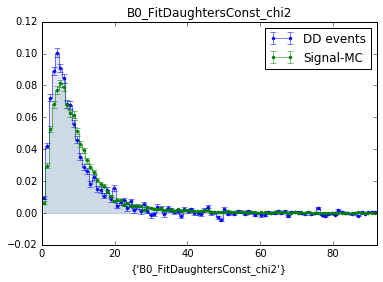

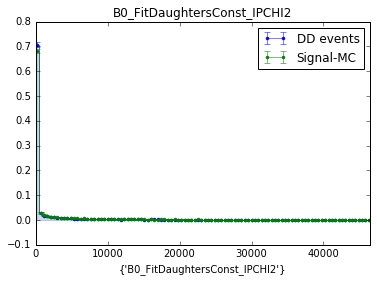

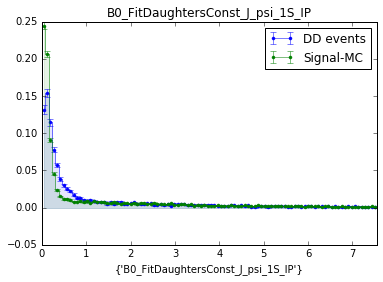

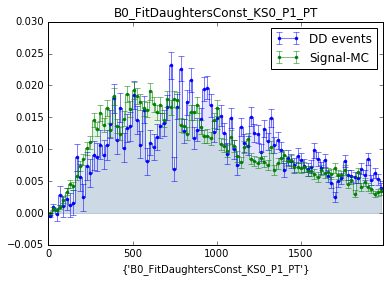

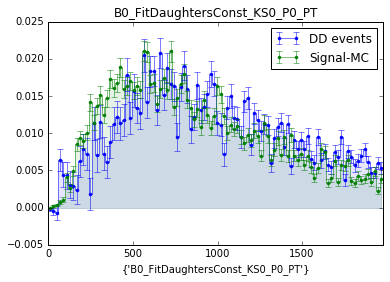

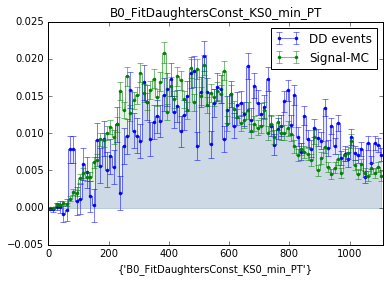

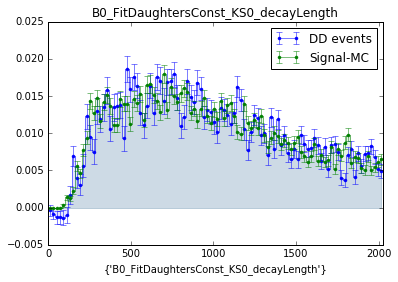

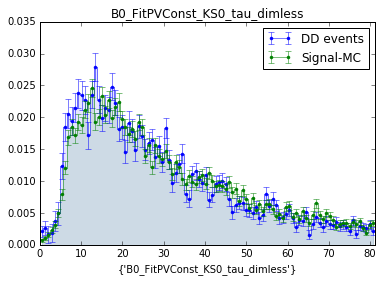

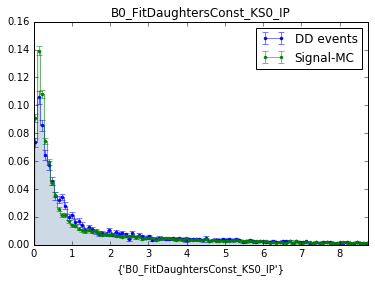

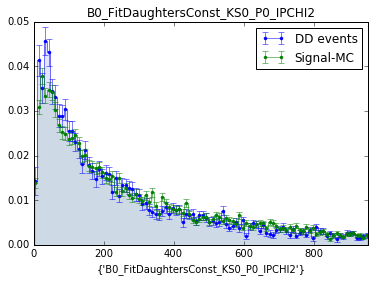

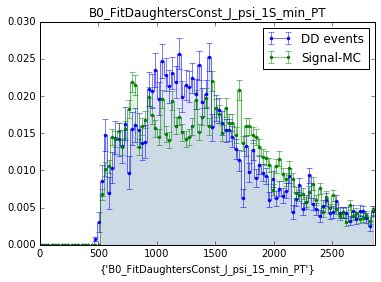

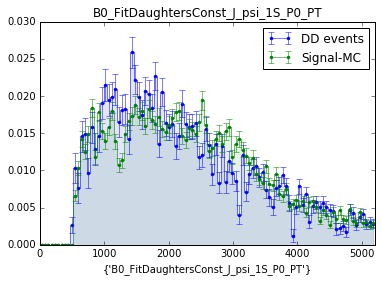

In [18]:
#Check bdt-variables in downstream events
for feature in bdt_features:
    plotter = Plotter('/home/chasenberg/repos/b2cc_sin2beta/notebooks/selection/plots/bdt_check/dd_events/2015')
    plotter.create_plots([dd_2015_df,dd_mc], feature, weightvars=['SigYield_sw','mc_weight']
    ,component_labels=['DD events','Signal-MC'])
    plotter[feature].set_range(0,dd_2015_df[feature].quantile(0.95))
    plotter.plot()

2016 Data
----------------

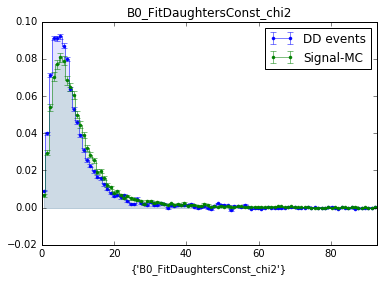

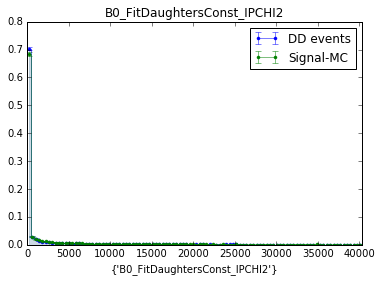

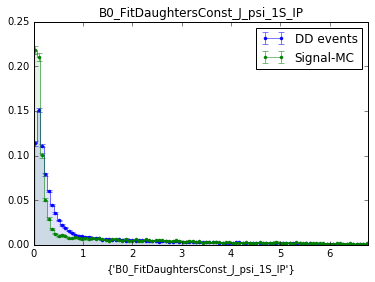

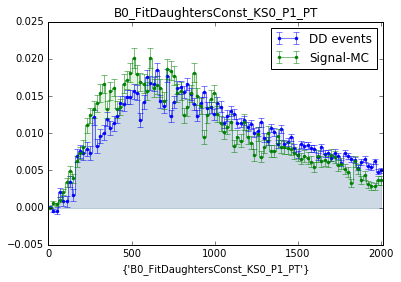

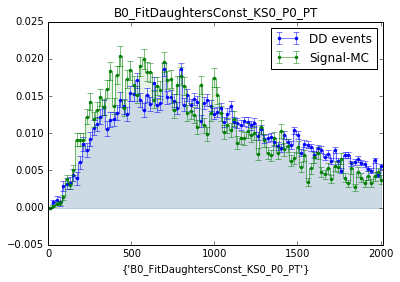

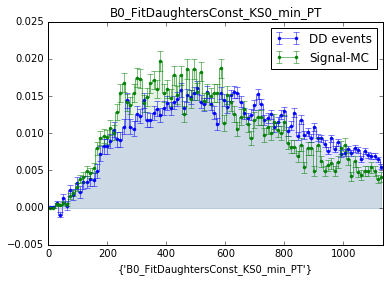

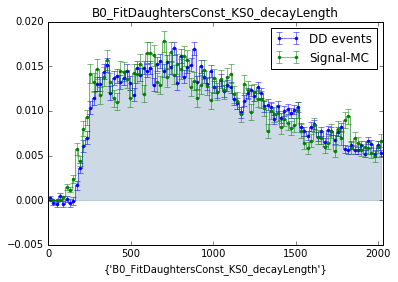

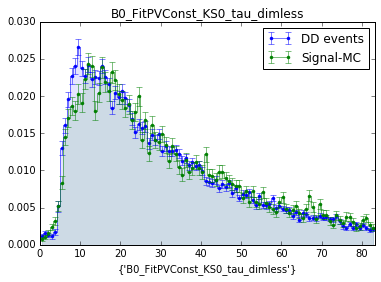

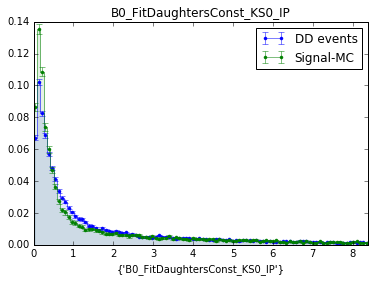

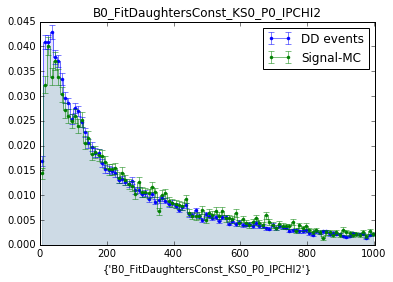

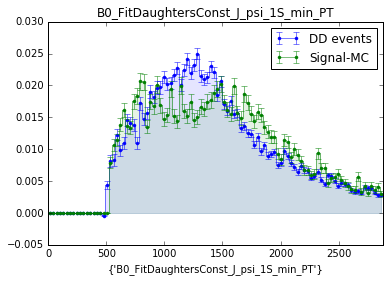

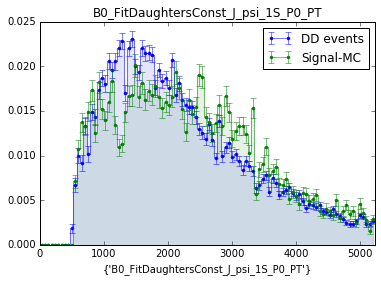

In [19]:
#Check bdt-variables in downstream events
for feature in bdt_features:
    plotter = Plotter('/home/chasenberg/repos/b2cc_sin2beta/notebooks/selection/plots/bdt_check/dd_events/2016')
    plotter.create_plots([dd_2016_df,dd_mc], feature, weightvars=['SigYield_sw','mc_weight']
    ,component_labels=['DD events','Signal-MC'])
    plotter[feature].set_range(0,dd_2016_df[feature].quantile(0.95))
    plotter.plot()

Now Check LL events
-----------------

2015 Data
------------

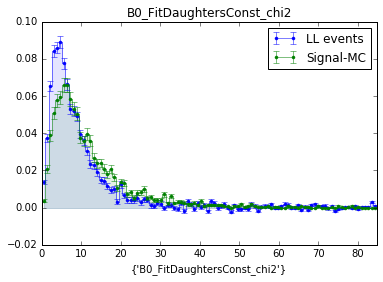

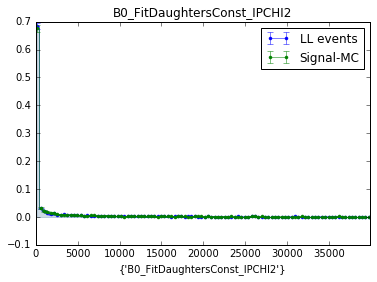

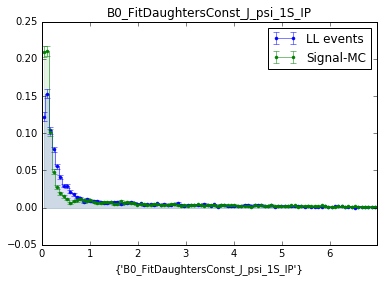

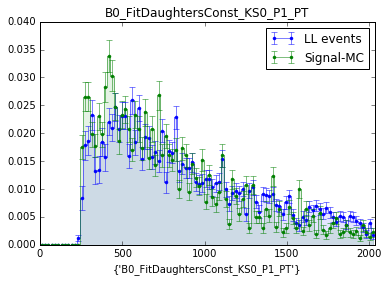

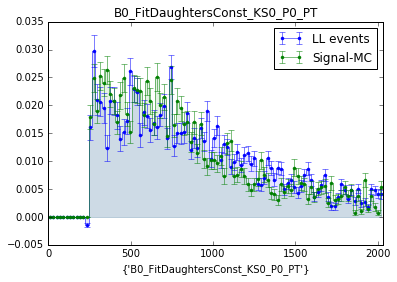

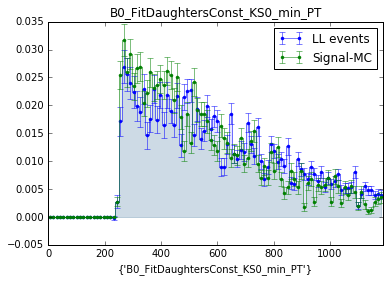

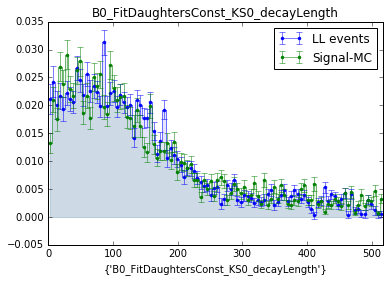

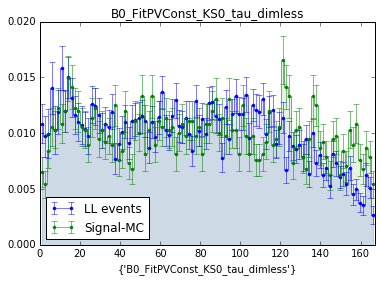

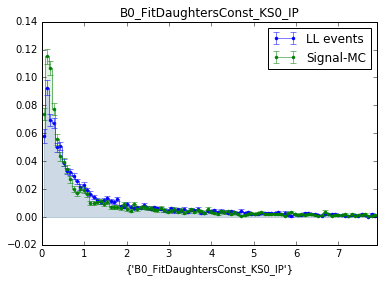

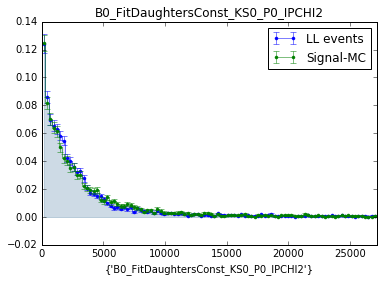

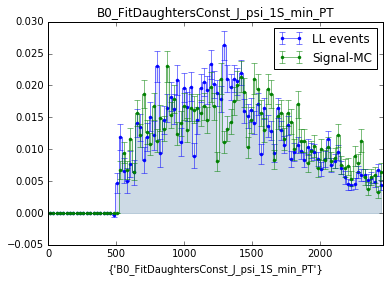

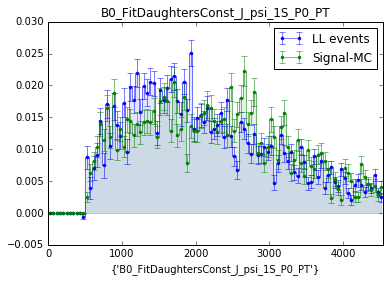

In [20]:
#Check bdt-variables in downstream events
for feature in bdt_features:
    plotter = Plotter('/home/chasenberg/repos/b2cc_sin2beta/notebooks/selection/plots/bdt_check/ll_events/2015')
    plotter.create_plots([ll_2015_df,ll_mc], feature, weightvars=['SigYield_sw','mc_weight']
    ,component_labels=['LL events','Signal-MC'])
    plotter[feature].set_range(0,ll_2015_df[feature].quantile(0.95))
    plotter.plot()

2016 Data
----------------

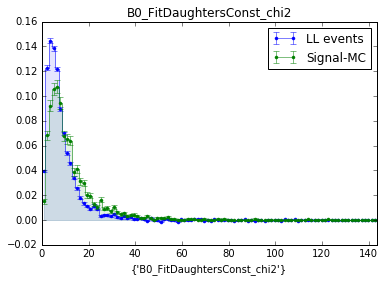

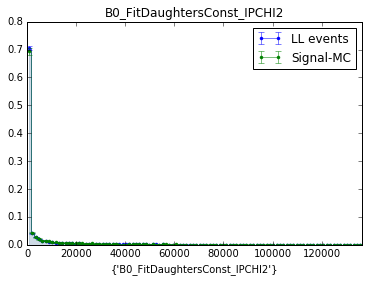

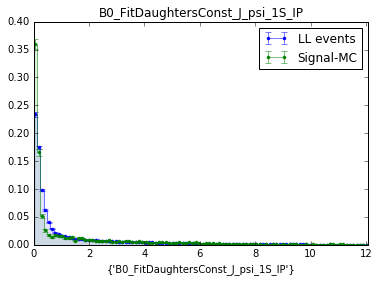

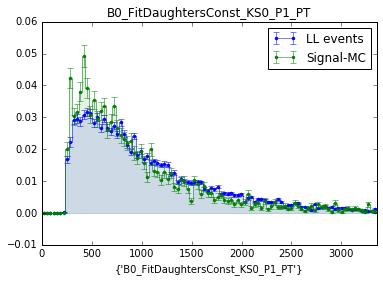

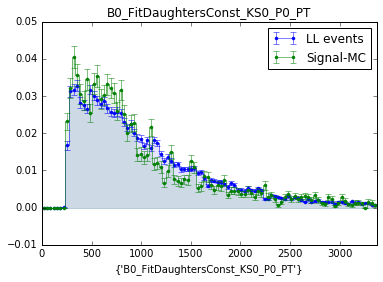

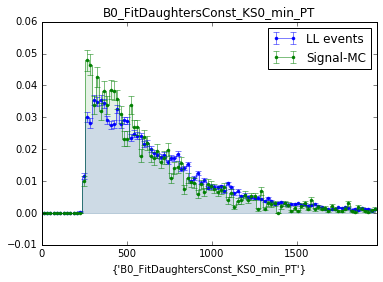

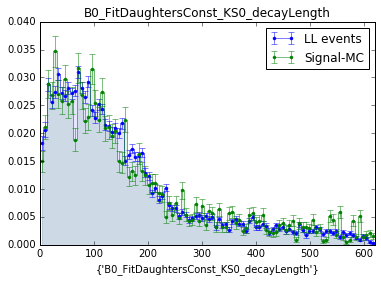

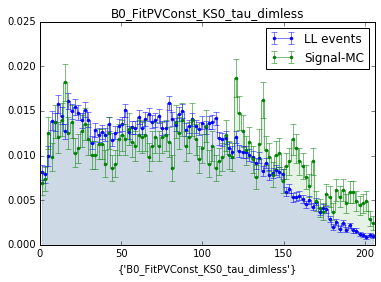

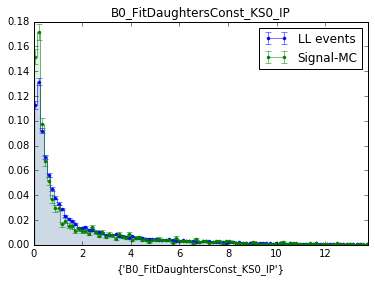

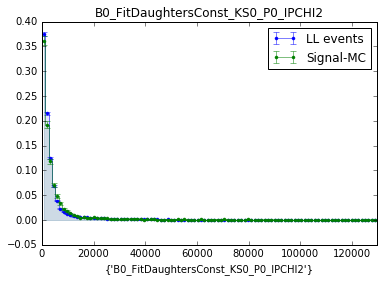

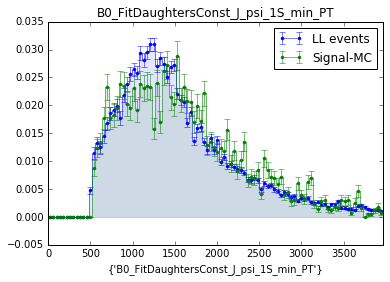

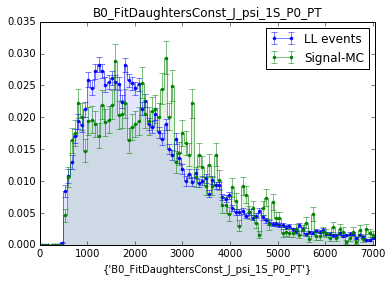

In [21]:
#Check bdt-variables in downstream events
for feature in bdt_features:
    plotter = Plotter('/home/chasenberg/repos/b2cc_sin2beta/notebooks/selection/plots/bdt_check/ll_events/2016')
    plotter.create_plots([ll_2016_df,ll_mc], feature, weightvars=['SigYield_sw','mc_weight']
    ,component_labels=['LL events','Signal-MC'])
    plotter[feature].set_range(0,ll_2016_df[feature].quantile(0.99))
    plotter.plot()

Check DD/LL events on merged 2015/2016 data
-------------------------------------------------------------

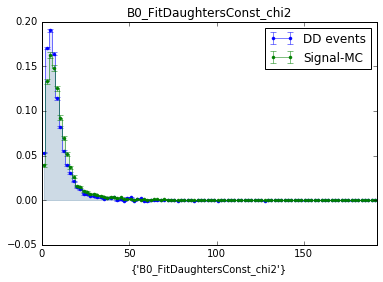

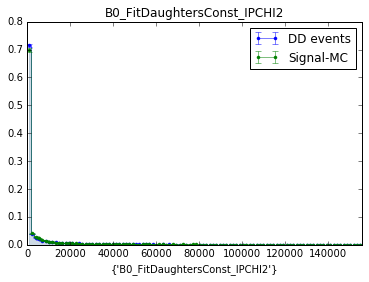

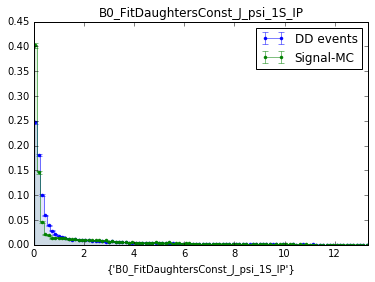

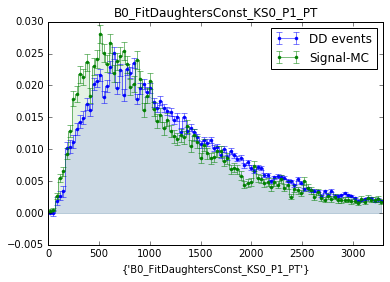

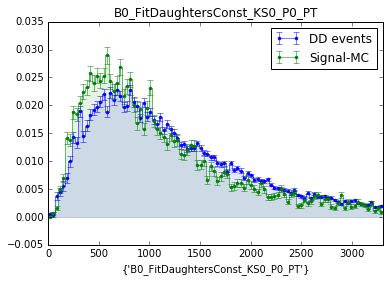

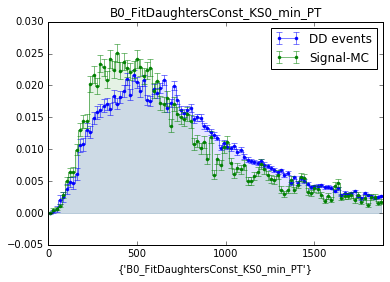

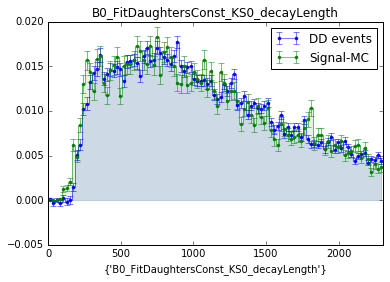

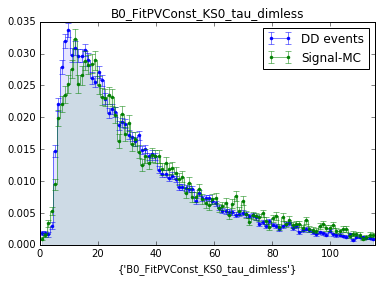

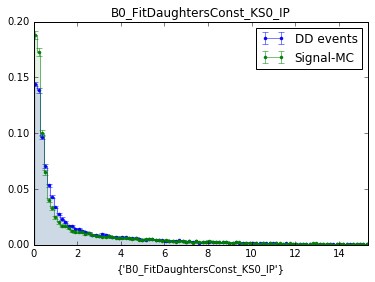

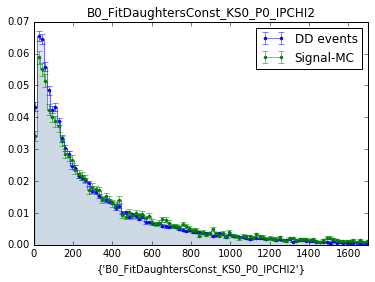

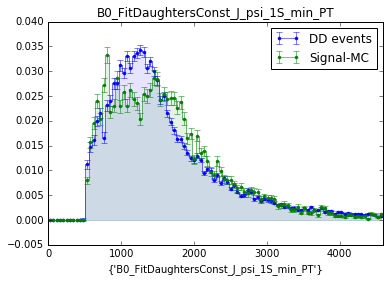

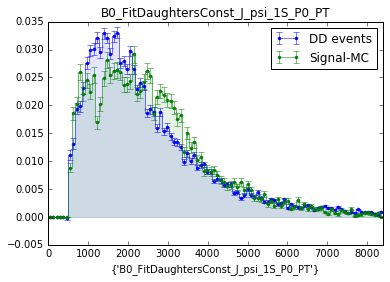

In [22]:
#Check bdt-variables in downstream events
for feature in bdt_features:
    plotter = Plotter('/home/chasenberg/repos/b2cc_sin2beta/notebooks/selection/plots/bdt_check/dd_events/')
    plotter.create_plots([dd_frame,dd_mc], feature, weightvars=['SigYield_sw','mc_weight']
    ,component_labels=['DD events','Signal-MC'])
    plotter[feature].set_range(0,dd_frame[feature].quantile(0.99))
    plotter.plot()

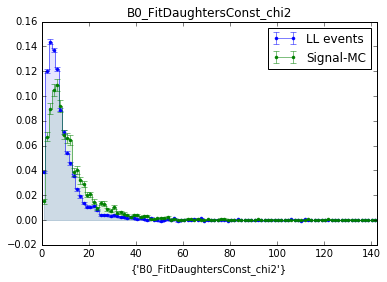

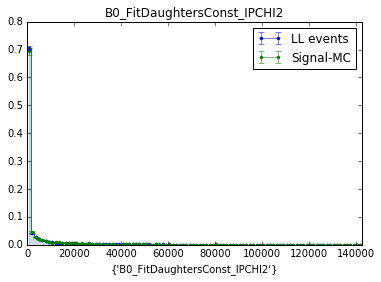

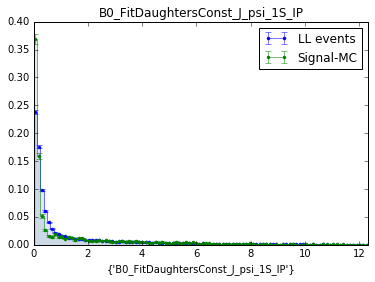

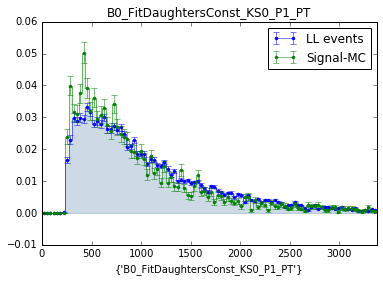

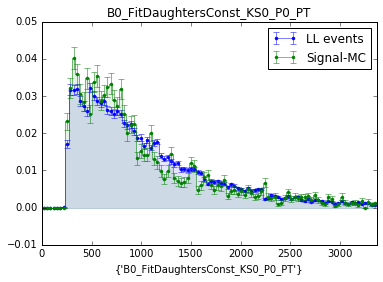

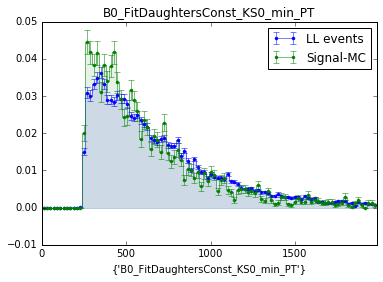

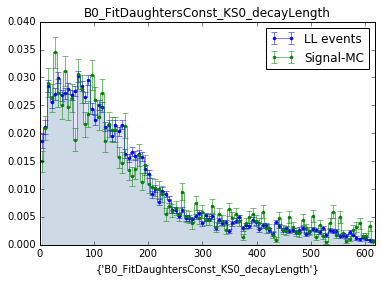

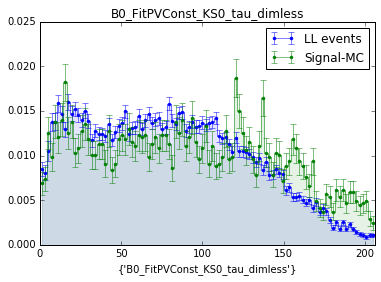

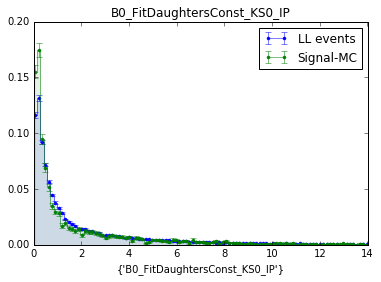

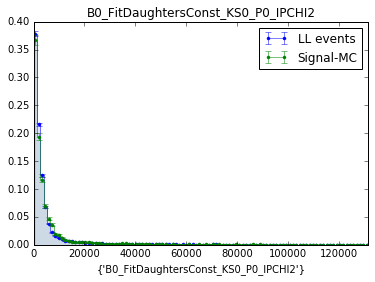

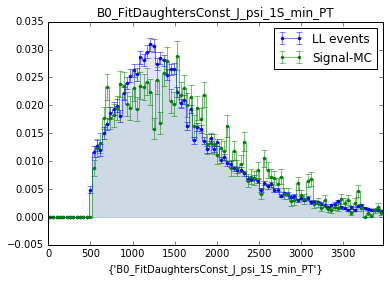

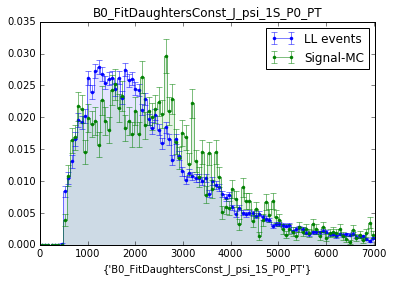

In [23]:
#Check bdt-variables in longtrack events
for feature in bdt_features:
    plotter = Plotter('/home/chasenberg/repos/b2cc_sin2beta/notebooks/selection/plots/bdt_check/ll_events')
    plotter.create_plots([ll_frame,ll_mc], feature, weightvars=['SigYield_sw','mc_weight']
    ,component_labels=['LL events','Signal-MC'])
    plotter[feature].set_range(0,ll_frame[feature].quantile(0.99))
    plotter.plot()

Just standard check: sWeighted data vs. mc, no cuts